In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py
import pickle

import logging

import gym
import numpy as np
import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv, VecFrameStack
from stable_baselines3.common.vec_env import VecTransposeImage
from stable_baselines3.common.atari_wrappers import AtariWrapper

from drlhp.reward_predictor_core_network import net_cnn
from drlhp.HumanPreferencesEnvWrapper import _make_reward_predictor

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

# Let's first look at the Seaquest with segment length = 10

This is at SeaquestNoFrameskip-v4_1

In [2]:
ckpt_dir = Path('/home/eric/interpreting-rewards/scripts/output/drlhp/ppo/SeaquestNoFrameskip-v4_1/reward_predictor_checkpoints')


log_dir = Path('logs')
logger = logging.getLogger("testytest")

obs_shape = (84, 84, 4)

In [3]:
rp = _make_reward_predictor(reward_predictor_network=net_cnn,
                           log_dir=log_dir,
                           obs_shape=obs_shape,
                           logger=logger,
                           checkpoint_dir=ckpt_dir)

RewardPredictorEnsemble created
RewardPredictorEnsemble initialized


In [4]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [5]:
env_id = "SeaquestNoFrameskip-v4"
folder = "../scripts/output/drlhp"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [6]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)
env = gym.make(env_id)
env = AtariWrapper(env, frame_skip=1)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, n_stack=4)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

/home/eric/miniconda3/envs/interp/lib/python3.7/site-packages/cloudpickle/cloudpickle.py:704: UserWarning: A pickle file created using an old (<=1.4.1) version of cloudpicke is currently being loaded. This is not supported by cloudpickle and will break in cloudpickle 1.7
  "will break in cloudpickle 1.7", category=UserWarning


In [7]:
obs = env.reset()
for i in range(100):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break

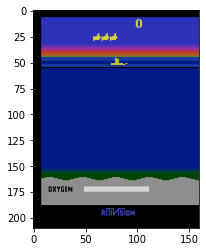

In [8]:
plt.imshow(env.render(mode='rgb_array'))

In [9]:
# obs = env.reset()
for i in range(20):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break
    print(rp.reward(obs))

[0.]
[-0.03535533]
[-0.05743767]
[0.05392475]
[0.07985998]
[-0.00083598]
[0.06230435]
[0.06216824]
[-0.07990687]
[-0.02675648]
[0.02876433]
[0.03442062]
[-0.01361886]
[0.0272374]
[0.04581897]
[-0.00618767]
[-0.00164031]
[0.04264713]
[0.000507]
[-0.01824165]


In [10]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

In [11]:
obs = env.reset()

/home/eric/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


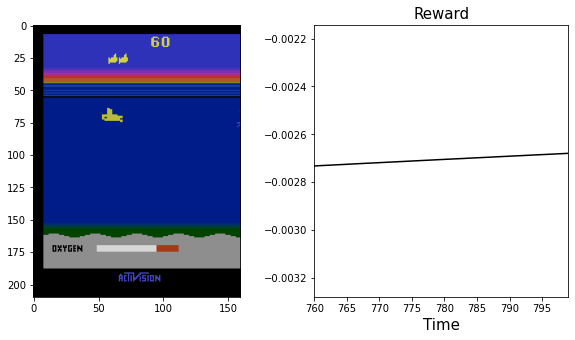

In [13]:
TIMESTEPS = 800

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Seaquest DRLHP Reward vs. Time", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 5))
ax2.set_xlabel("Time", fontsize=15)
ax2.set_title("Reward", fontsize=15)

obs = env.reset()
imshow = ax.imshow(env.render(mode='rgb_array'))
timeseries = ax2.plot([], [], c='black')[0]
rewards = []
with writer.saving(fig, "../videos/seaquest/seaquest_drlhp_sl10_reward_timeseries.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
        screenshot = env.render(mode='rgb_array')
        imshow.set_data(screenshot)
        
        reward = rp.reward(obs)[0]
        rewards.append(reward)
        ax2.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
        ax2.set_ylim(min(rewards[-40:]) - 0.2*abs(min(rewards[-40:])), max(rewards[-40:]) + 0.2*abs(max(rewards[-40:])))
        # ax2.set_yscale('log')
        timeseries.set_data(list(range(i+1))[-40:], rewards[-40:])
        writer.grab_frame()
        # plt.subplots_adjust(wspace=0.2)

In [14]:
def create_circular_mask(h, w, center, radius=5):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
    mask = dist_from_center <= radius
    return np.array(mask, dtype=np.float32)

def max_k(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return items

def max_k_and_values(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return list(zip(items, values))

def reward_model_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_copy = np.copy(obs)
    baseline = model.reward(obs_copy)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_copy[0, :, :, k]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_copy[0, :, :, k] = img*(1 - M) + A*M
    modified = model.reward(obs_copy)
    return abs(baseline[0] - modified[0])**2


## Let's look at the saliency map now:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


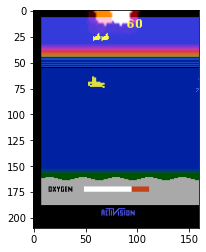

In [17]:
radius = 5
stride = 4

pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rp, obs, e, radius=radius))
screenshot = env.render(mode='rgb_array')
screenshot = screenshot / screenshot.max()
max_value = pairs[0][1]
heatmap = np.zeros((210, 160, 3))
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value / max_value)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    heatmap = spot + (1-spot)*heatmap
#     screenshot = screenshot / screenshot.max()
#     screenshot[:, :, 2] += region * a
screenshot = screenshot + heatmap

plt.imshow(screenshot)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/eric/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

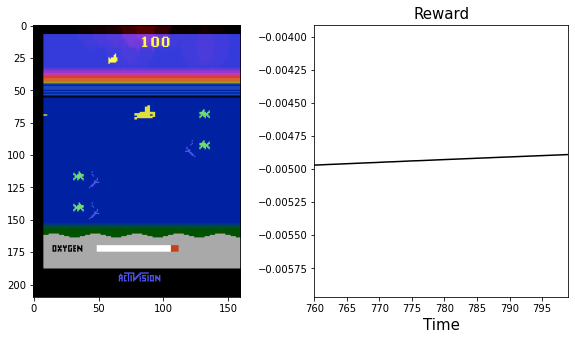

In [19]:
radius = 7
stride = 6

TIMESTEPS = 800

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Seaquest DRLHP Reward vs. Time", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 5))
ax2.set_xlabel("Time", fontsize=15)
ax2.set_title("Reward", fontsize=15)

obs = env.reset()
imshow = ax.imshow(env.render(mode='rgb_array'))
timeseries = ax2.plot([], [], c='black')[0]
rewards = []
with writer.saving(fig, "../videos/seaquest/seaquest_drlhp_sl10_reward_timeseries_with_saliency.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
        screenshot = env.render(mode='rgb_array')
        
        screenshot = env.render(mode='rgb_array')
        screenshot = screenshot / screenshot.max()
        
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rp, obs, e, radius=radius))
        # max_value = pairs[0][1]
        heatmap = np.zeros((210, 160, 3))
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            heatmap = spot + (1-spot)*heatmap
        #     screenshot = screenshot / screenshot.max()
        #     screenshot[:, :, 2] += region * a
        screenshot = screenshot + heatmap
        imshow.set_data(screenshot)
        
        reward = rp.reward(obs)[0]
        rewards.append(reward)
        ax2.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
        ax2.set_ylim(min(rewards[-40:]) - 0.2*abs(min(rewards[-40:])), max(rewards[-40:]) + 0.2*abs(max(rewards[-40:])))
        # ax2.set_yscale('log')
        timeseries.set_data(list(range(i+1))[-40:], rewards[-40:])
        writer.grab_frame()
        # plt.subplots_adjust(wspace=0.2)

# Let's look at Seaquest with segment length = 40

In [2]:
ckpt_dir = Path('/home/eric/interpreting-rewards/scripts/output/drlhp/ppo/SeaquestNoFrameskip-v4_2/reward_predictor_checkpoints')


log_dir = Path('logs')
logger = logging.getLogger("testytest")

obs_shape = (84, 84, 4)

In [3]:
rp = _make_reward_predictor(reward_predictor_network=net_cnn,
                           log_dir=log_dir,
                           obs_shape=obs_shape,
                           logger=logger,
                           checkpoint_dir=ckpt_dir)

RewardPredictorEnsemble created
RewardPredictorEnsemble initialized


In [4]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [5]:
env_id = "SeaquestNoFrameskip-v4"
folder = "../scripts/output/drlhp"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 2
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [6]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)
env = gym.make(env_id)
env = AtariWrapper(env, frame_skip=1)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, n_stack=4)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

/home/eric/miniconda3/envs/interp/lib/python3.7/site-packages/cloudpickle/cloudpickle.py:704: UserWarning: A pickle file created using an old (<=1.4.1) version of cloudpicke is currently being loaded. This is not supported by cloudpickle and will break in cloudpickle 1.7
  "will break in cloudpickle 1.7", category=UserWarning


In [ ]:
plt.figure(figsize=(10, 4))
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.imshow(obs[0, :, :, k])

In [ ]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

In [ ]:
radius = 7
stride = 6

TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()
for i in range(500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break

imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "../videos/pong/pong_drlhp_reward_model_saliency.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        locs = max_k(5, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rp, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
#         screenshot = screenshot * 0.4
        for loc in locs:
                r, g, b, a = matplotlib.cm.hot(value)
                m = max(r, g, b)
                region = create_circular_mask(84, 84, center=loc, radius=radius)
                region = skimage.transform.resize(region, (210, 160))
                spot = np.zeros((210, 160, 3))
                spot[:, :, 0] = r * region / m
                spot[:, :, 1] = g * region / m
                spot[:, :, 2] = b * region / m
                spot = spot * a
                screenshot = spot + (1-spot)*screenshot
                screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        writer.grab_frame()

In [ ]:
radius = 5
stride = 4

TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 5))
ax2.set_xlabel("Time", fontsize=15)
ax2.set_title("Max Saliency", fontsize=15)

obs = env.reset()
imshow = ax.imshow(env.get_images()[0])
timeseries = ax2.plot([], [], c='black')[0]
max_saliencies = []
with writer.saving(fig, "../videos/pong/pong_drlhp_reward_model_saliency_withtimeseries.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rp, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        max_value = pairs[0][1]
        max_saliencies.append(max_value)
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value / max_value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        ax2.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
#         ax2.set_yscale('log')
        ax2.set_ylim(min(max_saliencies), 1.1*max(max_saliencies))
        timeseries.set_data(list(range(i+1))[-40:], max_saliencies[-40:])
        writer.grab_frame()
#         plt.subplots_adjust(wspace=0.2)

In [ ]:
radius = 5
stride = 4

pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rp, obs, e, radius=radius))
max_value = pairs[0][1]
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
# max_value = pairs[0][1]
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value / max_value)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    screenshot = spot + (1-spot)*screenshot
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

[0.]
[-0.03535534]
[-0.02892016]
[-0.02504062]
[-0.02239468]
[-0.02044214]
[-0.01892495]
[-0.0177022]
[-0.01668948]
[-0.01583277]
[-0.0150956]
[-0.01445283]
[-0.0138858]
[-0.01338045]
[-0.01292662]
[-0.0125161]
[-0.01214235]
[-0.01180018]
[-0.01148541]
[-0.01119456]


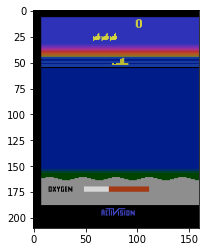

In [7]:
# obs = env.reset()
for i in range(20):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break
    print(rp.reward(obs))

plt.imshow(env.render(mode='rgb_array'))

In [8]:
def create_circular_mask(h, w, center, radius=5):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
    mask = dist_from_center <= radius
    return np.array(mask, dtype=np.float32)

def max_k(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return items

def max_k_and_values(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return list(zip(items, values))

def reward_model_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_copy = np.copy(obs)
    baseline = model.reward(obs_copy)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_copy[0, :, :, k]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_copy[0, :, :, k] = img*(1 - M) + A*M
    modified = model.reward(obs_copy)
    return abs(baseline[0] - modified[0])**2


In [10]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/eric/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

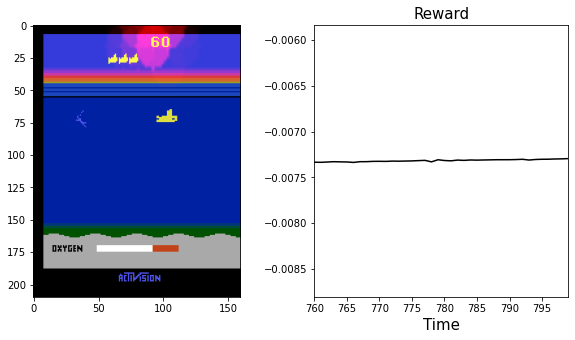

In [11]:
radius = 7
stride = 6

TIMESTEPS = 800

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Seaquest DRLHP Reward vs. Time", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 5))
ax2.set_xlabel("Time", fontsize=15)
ax2.set_title("Reward", fontsize=15)

obs = env.reset()
imshow = ax.imshow(env.render(mode='rgb_array'))
timeseries = ax2.plot([], [], c='black')[0]
rewards = []
with writer.saving(fig, "../videos/seaquest/seaquest_drlhp_sl40_reward_timeseries_with_saliency.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
        screenshot = env.render(mode='rgb_array')
        
        screenshot = env.render(mode='rgb_array')
        screenshot = screenshot / screenshot.max()
        
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rp, obs, e, radius=radius))
        # max_value = pairs[0][1]
        heatmap = np.zeros((210, 160, 3))
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            heatmap = spot + (1-spot)*heatmap
        #     screenshot = screenshot / screenshot.max()
        #     screenshot[:, :, 2] += region * a
        screenshot = screenshot + heatmap
        imshow.set_data(screenshot)
        
        reward = rp.reward(obs)[0]
        rewards.append(reward)
        ax2.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
        ax2.set_ylim(min(rewards[-40:]) - 0.2*abs(min(rewards[-40:])), max(rewards[-40:]) + 0.2*abs(max(rewards[-40:])))
        # ax2.set_yscale('log')
        timeseries.set_data(list(range(i+1))[-40:], rewards[-40:])
        writer.grab_frame()
        # plt.subplots_adjust(wspace=0.2)

# Okay this reward model is pretty sparsified already. It has a strong peak exactly when the score changes, and the score is most salient during those transitions.